In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Load featured data
df = pd.read_parquet('../data/train_featured.parquet')

print(f"Shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Columns: {df.columns.tolist()}")

Shape: (3000888, 36)
Date range: 2013-01-01 00:00:00 to 2017-08-15 00:00:00
Columns: ['id', 'date', 'store_nbr', 'family', 'sales', 'onpromotion', 'day_of_week', 'day_of_month', 'month', 'year', 'week_of_year', 'is_weekend', 'is_month_start', 'is_month_end', 'lag_7', 'lag_14', 'lag_28', 'lag_364', 'rolling_7_mean', 'rolling_7_std', 'rolling_14_mean', 'rolling_28_mean', 'is_national_holiday', 'holiday_type', 'is_transferred', 'days_to_next_holiday', 'days_since_last_holiday', 'oil_price', 'oil_lag_7', 'oil_rolling_7_mean', 'city', 'state', 'type', 'cluster', 'promo_lag_7', 'promo_lag_14']


Train: 2013-01-01 00:00:00 to 2017-07-31 00:00:00 (1669 days)
Test:  2017-08-01 00:00:00 to 2017-08-15 00:00:00 (15 days)

Train rows: 2,974,158
Test rows:  26,730


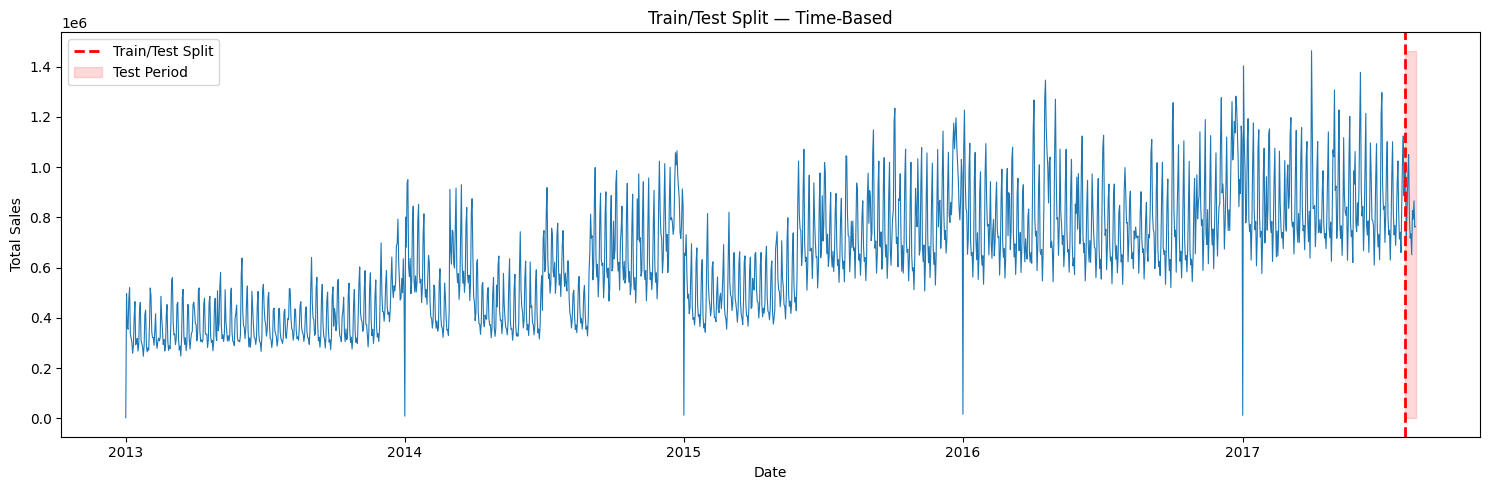

In [2]:
# Time-based split: train on past, test on future
# Last 15 days as test set (Aug 1-15, 2017)
split_date = pd.Timestamp('2017-08-01')

train_data = df[df['date'] < split_date].copy()
test_data = df[df['date'] >= split_date].copy()

print(f"Train: {train_data['date'].min()} to {train_data['date'].max()} ({train_data['date'].nunique()} days)")
print(f"Test:  {test_data['date'].min()} to {test_data['date'].max()} ({test_data['date'].nunique()} days)")
print(f"\nTrain rows: {len(train_data):,}")
print(f"Test rows:  {len(test_data):,}")

# Visualize the split
daily_sales = df.groupby('date')['sales'].sum()

plt.figure(figsize=(15, 5))
plt.plot(daily_sales.index, daily_sales.values, linewidth=0.8)
plt.axvline(x=split_date, color='red', linestyle='--', linewidth=2, label='Train/Test Split')
plt.fill_betweenx([0, daily_sales.max()], split_date, daily_sales.index.max(), 
                   alpha=0.15, color='red', label='Test Period')
plt.title('Train/Test Split — Time-Based')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.legend()
plt.tight_layout()
plt.show()

In [3]:
# Define evaluation metrics for time series

def rmsle(y_true, y_pred):
    """Root Mean Squared Log Error — our primary metric"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    y_pred = np.maximum(y_pred, 0)  # Clip negatives
    return np.sqrt(np.mean((np.log1p(y_true) - np.log1p(y_pred)) ** 2))

def rmse(y_true, y_pred):
    """Root Mean Squared Error"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def mape(y_true, y_pred):
    """Mean Absolute Percentage Error — excludes zeros to avoid division by zero"""
    y_true = np.array(y_true, dtype=float)
    y_pred = np.array(y_pred, dtype=float)
    mask = y_true > 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Store all results
all_results = []

def evaluate_model(y_true, y_pred, model_name):
    """Evaluate and store results"""
    results = {
        'Model': model_name,
        'RMSLE': rmsle(y_true, y_pred),
        'RMSE': rmse(y_true, y_pred),
        'MAPE': mape(y_true, y_pred)
    }
    print(f"\n{model_name}:")
    print(f"  RMSLE: {results['RMSLE']:.4f}")
    print(f"  RMSE:  {results['RMSE']:.2f}")
    print(f"  MAPE:  {results['MAPE']:.2f}%")
    all_results.append(results)
    return results

In [4]:
# Naive forecast: "Sales today = sales exactly 7 days ago"
# Uses the lag_7 feature we already created

y_true = test_data['sales'].values
naive_pred = test_data['lag_7'].values

evaluate_model(y_true, naive_pred, "Naive (Last Week)")


Naive (Last Week):
  RMSLE: 0.5690
  RMSE:  353.80
  MAPE:  49.60%


{'Model': 'Naive (Last Week)',
 'RMSLE': np.float64(0.5690269172227614),
 'RMSE': np.float64(353.8005626822748),
 'MAPE': np.float64(49.60479889150458)}

In [5]:
# Seasonal naive: "Sales today = sales same day last year"
# Uses the lag_364 feature we already created

seasonal_pred = test_data['lag_364'].values

evaluate_model(y_true, seasonal_pred, "Seasonal Naive (Last Year)")


Seasonal Naive (Last Year):
  RMSLE: 0.9634
  RMSE:  442.23
  MAPE:  54.77%


{'Model': 'Seasonal Naive (Last Year)',
 'RMSLE': np.float64(0.9633926274872822),
 'RMSE': np.float64(442.2252909943341),
 'MAPE': np.float64(54.773548583342844)}

In [6]:
# Moving average: "Sales today = average of last 7 days"
# Uses the rolling_7_mean feature we already created

ma_pred = test_data['rolling_7_mean'].values

evaluate_model(y_true, ma_pred, "Moving Average (7-day)")   


Moving Average (7-day):
  RMSLE: 0.4473
  RMSE:  302.78
  MAPE:  43.89%


{'Model': 'Moving Average (7-day)',
 'RMSLE': np.float64(0.44727051059242723),
 'RMSE': np.float64(302.7800456130685),
 'MAPE': np.float64(43.89401566126625)}

In [9]:
# Prophet: Statistical forecasting model by Meta
# Handles trend + multiple seasonalities automatically
# 
# Too slow for all 1,782 series — demo on one high-volume store-family
# Then compare FAIRLY against other baselines on the SAME subset

# Install if needed (uncomment):
# !pip install prophet

from prophet import Prophet
import time

# Select highest-volume store-family for demo
demo_store = 44
demo_family = 'GROCERY I'

subset = df[(df['store_nbr'] == demo_store) & (df['family'] == demo_family)].copy()
subset_train = subset[subset['date'] < split_date]
subset_test = subset[subset['date'] >= split_date]

# --- Prophet ---
prophet_df = subset_train[['date', 'sales']].copy()
prophet_df.columns = ['ds', 'y']

start_time = time.time()
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_df)
prophet_time = time.time() - start_time

# Predict
future = subset_test[['date']].copy()
future.columns = ['ds']
forecast = prophet_model.predict(future)
prophet_pred = forecast['yhat'].values.clip(0)  # No negative sales

print(f"Prophet fit time: {prophet_time:.1f}s")

# --- Fair comparison on SAME subset ---
subset_y_true = subset_test['sales'].values
subset_naive = subset_test['lag_7'].values
subset_seasonal = subset_test['lag_364'].values
subset_ma = subset_test['rolling_7_mean'].values

print("\n" + "=" * 60)
print(f"FAIR COMPARISON: Store {demo_store}, {demo_family}")
print("=" * 60)

evaluate_model(subset_y_true, subset_naive, f"Naive (Lag 7) — Subset")
evaluate_model(subset_y_true, subset_seasonal, f"Seasonal Naive — Subset")
evaluate_model(subset_y_true, subset_ma, f"Moving Average — Subset")
evaluate_model(subset_y_true, prophet_pred, f"Prophet — Subset")

Importing plotly failed. Interactive plots will not work.
13:16:36 - cmdstanpy - INFO - Chain [1] start processing
13:16:36 - cmdstanpy - INFO - Chain [1] done processing


Prophet fit time: 0.6s

FAIR COMPARISON: Store 44, GROCERY I

Naive (Lag 7) — Subset:
  RMSLE: 0.2022
  RMSE:  2027.90
  MAPE:  17.86%

Seasonal Naive — Subset:
  RMSLE: 0.2073
  RMSE:  1946.61
  MAPE:  17.43%

Moving Average — Subset:
  RMSLE: 0.1728
  RMSE:  1656.15
  MAPE:  15.55%

Prophet — Subset:
  RMSLE: 0.1885
  RMSE:  2016.18
  MAPE:  16.96%


{'Model': 'Prophet — Subset',
 'RMSLE': np.float64(0.1884723166080669),
 'RMSE': np.float64(2016.1779490363165),
 'MAPE': np.float64(16.955305872895117)}

In [12]:
# ARIMA: Classical statistical model for time series
# Limitations: single seasonality, no exogenous features (basic version), slow
# We show it briefly for comparison

from statsmodels.tsa.arima.model import ARIMA

# Use same subset (Store 44, GROCERY I)
arima_train_series = subset_train.set_index('date')['sales']

# ARIMA(2,1,2) — a reasonable starting order
# (p=2: use last 2 values, d=1: first differencing, q=2: last 2 errors)
start_time = time.time()
arima_model = ARIMA(arima_train_series, order=(2, 1, 2))
arima_fit = arima_model.fit()
arima_time = time.time() - start_time

# Forecast
arima_forecast = arima_fit.forecast(steps=len(subset_test))
arima_pred = arima_forecast.values.clip(0)  # No negative sales

print(f"ARIMA fit time: {arima_time:.1f}s")

evaluate_model(subset_y_true, arima_pred, f"ARIMA(2,1,2) — Subset")

c:\Users\anant\miniconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anant\miniconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\anant\miniconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA fit time: 0.6s

ARIMA(2,1,2) — Subset:
  RMSLE: 0.2076
  RMSE:  1992.51
  MAPE:  20.53%


c:\Users\anant\miniconda3\envs\time-series\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


{'Model': 'ARIMA(2,1,2) — Subset',
 'RMSLE': np.float64(0.20761626772693675),
 'RMSE': np.float64(1992.5110928024064),
 'MAPE': np.float64(20.533984631406852)}

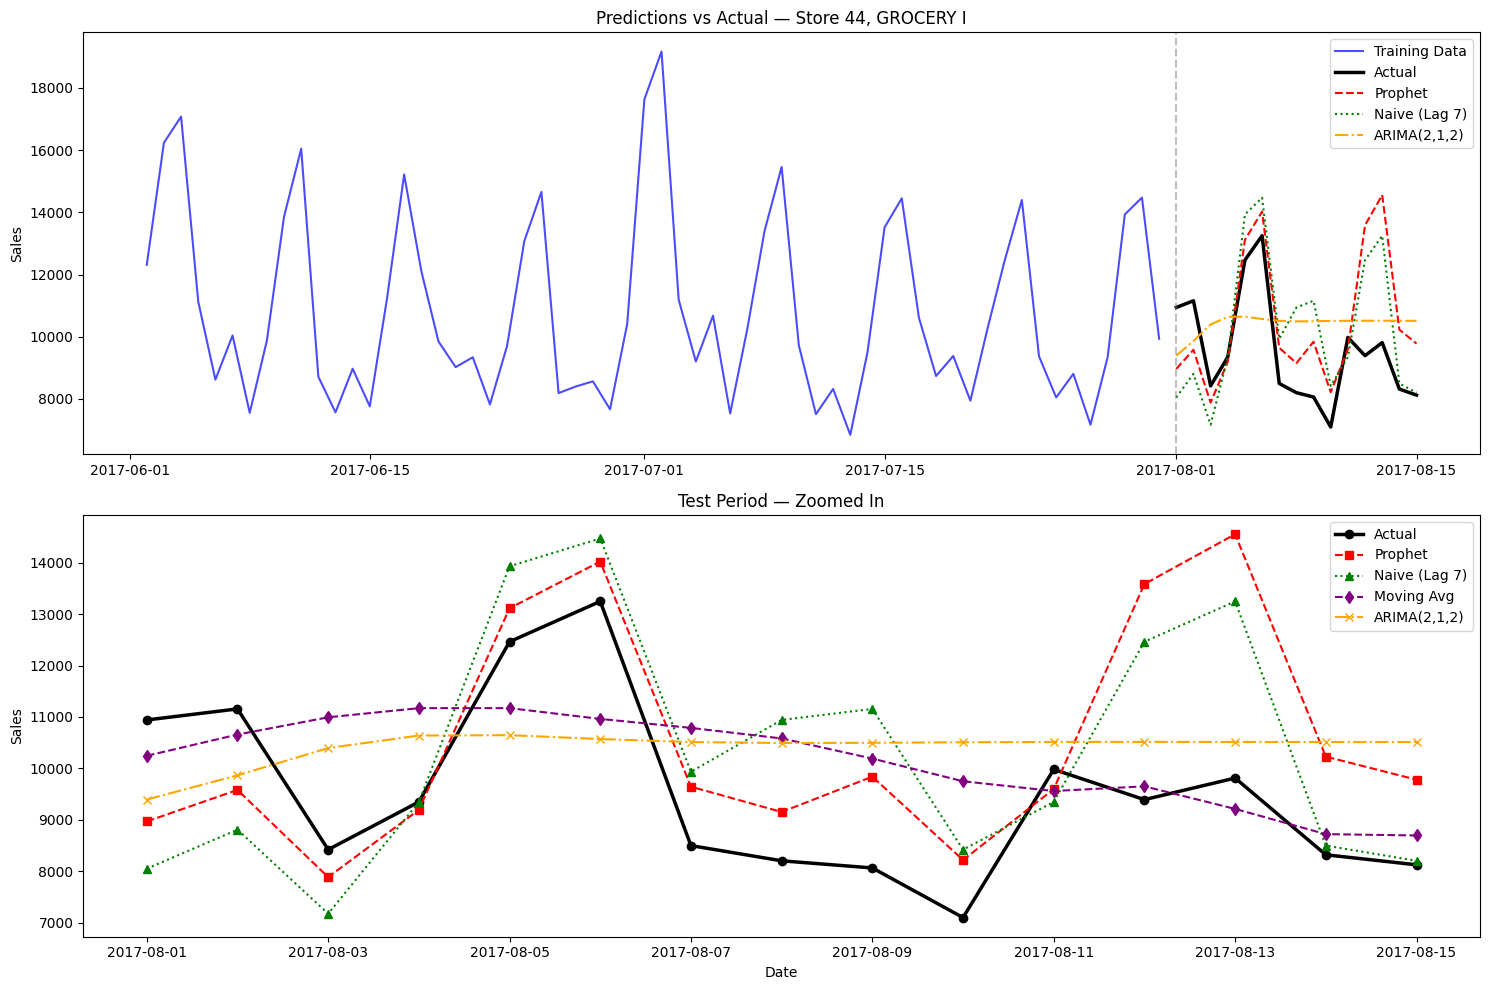

In [13]:
# Plot predictions vs actual for the subset comparison

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

# --- Plot 1: Last 60 days of training + all predictions ---
recent = subset[subset['date'] >= split_date - pd.Timedelta(days=60)]
recent_train = recent[recent['date'] < split_date]
recent_test = recent[recent['date'] >= split_date]

axes[0].plot(recent_train['date'], recent_train['sales'], label='Training Data', color='blue', alpha=0.7)
axes[0].plot(recent_test['date'], recent_test['sales'], label='Actual', color='black', linewidth=2.5)
axes[0].plot(recent_test['date'], prophet_pred, label='Prophet', color='red', linestyle='--', linewidth=1.5)
axes[0].plot(recent_test['date'], subset_naive, label='Naive (Lag 7)', color='green', linestyle=':', linewidth=1.5)
axes[0].plot(recent_test['date'], arima_pred, label='ARIMA(2,1,2)', color='orange', linestyle='-.', linewidth=1.5)
axes[0].axvline(x=split_date, color='gray', linestyle='--', alpha=0.5)
axes[0].set_title(f'Predictions vs Actual — Store {demo_store}, {demo_family}')
axes[0].set_ylabel('Sales')
axes[0].legend()

# --- Plot 2: Just the test period, zoomed in ---
axes[1].plot(recent_test['date'], recent_test['sales'], label='Actual', color='black', linewidth=2.5, marker='o')
axes[1].plot(recent_test['date'], prophet_pred, label='Prophet', color='red', linestyle='--', marker='s')
axes[1].plot(recent_test['date'], subset_naive, label='Naive (Lag 7)', color='green', linestyle=':', marker='^')
axes[1].plot(recent_test['date'], subset_ma, label='Moving Avg', color='purple', linestyle='--', marker='d')
axes[1].plot(recent_test['date'], arima_pred, label='ARIMA(2,1,2)', color='orange', linestyle='-.', marker='x')
axes[1].set_title('Test Period — Zoomed In')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales')
axes[1].legend()

plt.tight_layout()
plt.show()

GLOBAL BASELINES (All Stores, All Families)
                     Model    RMSLE       RMSE      MAPE
         Naive (Last Week) 0.569027 353.800563 49.604799
Seasonal Naive (Last Year) 0.963393 442.225291 54.773549
    Moving Average (7-day) 0.447271 302.780046 43.894016

SUBSET COMPARISON (Store 44, GROCERY I)
                  Model    RMSLE        RMSE      MAPE
 Naive (Lag 7) — Subset 0.202228 2027.902052 17.859818
Seasonal Naive — Subset 0.207313 1946.614651 17.427165
Moving Average — Subset 0.172832 1656.149245 15.548522
       Prophet — Subset 0.188472 2016.177949 16.955306
  ARIMA(2,1,2) — Subset 0.207616 1992.511093 20.533985

Best global baseline (RMSLE): Moving Average (7-day) (0.4473)
Best subset baseline (RMSLE): Moving Average — Subset (0.1728)


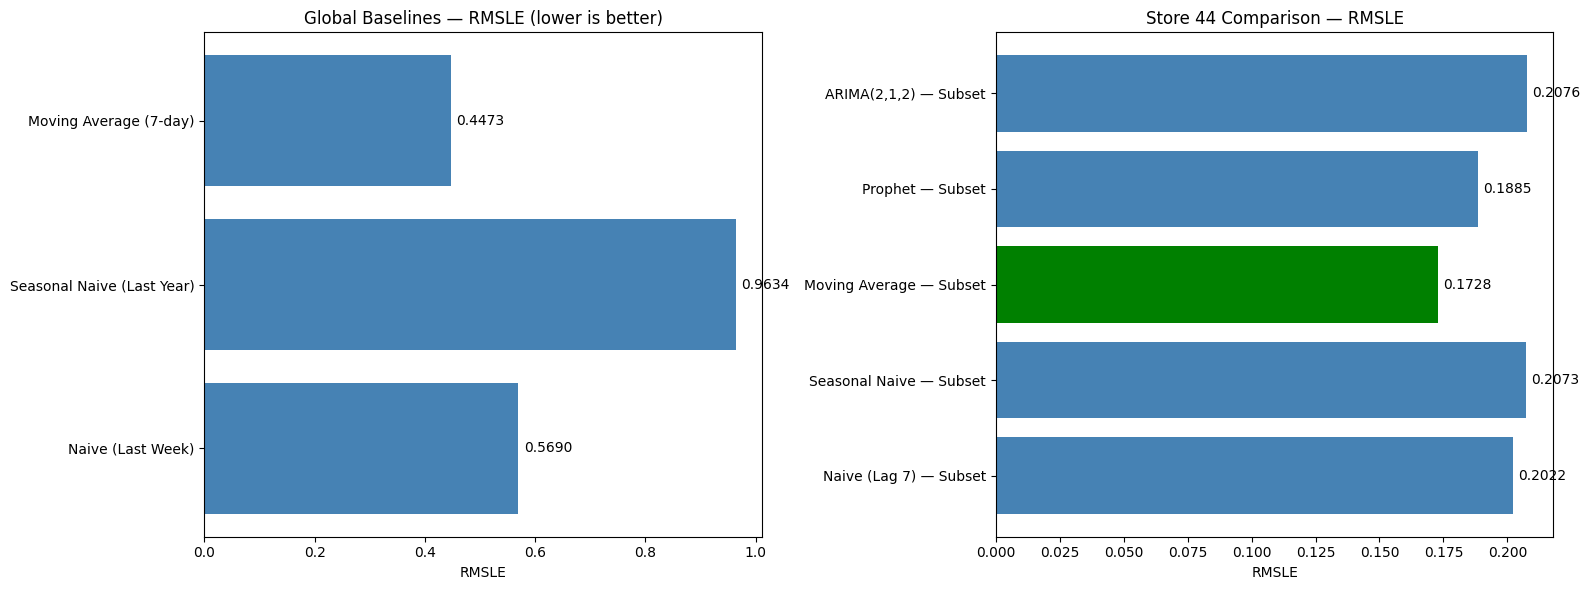

In [14]:
# Final results table
results_df = pd.DataFrame(all_results)

# Separate global vs subset results
global_results = results_df[~results_df['Model'].str.contains('Subset')].copy()
subset_results = results_df[results_df['Model'].str.contains('Subset')].copy()

print("=" * 60)
print("GLOBAL BASELINES (All Stores, All Families)")
print("=" * 60)
print(global_results.to_string(index=False))

print("\n" + "=" * 60)
print(f"SUBSET COMPARISON (Store {demo_store}, {demo_family})")
print("=" * 60)
print(subset_results.to_string(index=False))

# Find best model
best_global = global_results.loc[global_results['RMSLE'].idxmin()]
best_subset = subset_results.loc[subset_results['RMSLE'].idxmin()]

print(f"\nBest global baseline (RMSLE): {best_global['Model']} ({best_global['RMSLE']:.4f})")
print(f"Best subset baseline (RMSLE): {best_subset['Model']} ({best_subset['RMSLE']:.4f})")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Global comparison
axes[0].barh(global_results['Model'], global_results['RMSLE'], color='steelblue')
axes[0].set_title('Global Baselines — RMSLE (lower is better)')
axes[0].set_xlabel('RMSLE')
for i, v in enumerate(global_results['RMSLE']):
    axes[0].text(v + 0.01, i, f'{v:.4f}', va='center')

# Subset comparison
colors = ['steelblue'] * len(subset_results)
best_idx = subset_results['RMSLE'].values.argmin()
colors[best_idx] = 'green'
axes[1].barh(subset_results['Model'], subset_results['RMSLE'], color=colors)
axes[1].set_title(f'Store {demo_store} Comparison — RMSLE')
axes[1].set_xlabel('RMSLE')
for i, v in enumerate(subset_results['RMSLE']):
    axes[1].text(v + 0.002, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

# Summary: Baseline Models

## Approach

- **Time-based split:** Train on 2013-2017 Jul, test on Aug 1-15, 2017
- **No random splitting** — time series requires predicting future from past only
- **Three metrics:** RMSLE (primary), RMSE, MAPE

## Global Results (All Stores, All Families)

| Model | RMSLE | RMSE | MAPE |
|-------|-------|------|------|
| **Moving Average (7-day)** | **0.4473** | **302.78** | **43.89%** |
| Naive (Last Week) | 0.5690 | 353.80 | 49.60% |
| Seasonal Naive (Last Year) | 0.9634 | 442.23 | 54.77% |

## Subset Results (Store 44, GROCERY I)

| Model | RMSLE | RMSE | MAPE |
|-------|-------|------|------|
| **Moving Average** | **0.1728** | **1656** | **15.55%** |
| Prophet | 0.1885 | 2016 | 16.96% |
| Naive (Lag 7) | 0.2022 | 2028 | 17.86% |
| Seasonal Naive | 0.2073 | 1947 | 17.43% |
| ARIMA(2,1,2) | 0.2076 | 1993 | 20.53% |

## Key Insights

1. **Moving average is the baseline to beat** — simple 7-day average outperformed all methods
2. **Simple beats fancy** — Prophet and ARIMA didn't beat moving average for 15-day forecasts
3. **Seasonal naive was worst** — upward trend makes last year's values too low
4. **High-volume stores are more predictable** — RMSLE 0.17 (subset) vs 0.45 (global)
5. **MAPE ~44% globally is expected** — 31% zero-sales rows make percentage metrics noisy

## Target for Day 4

Beat RMSLE 0.4473 with XGBoost/LightGBM using all 31 engineered features.

## Next Steps

1. Train XGBoost/LightGBM on full feature set
2. Proper time series cross-validation
3. Hyperparameter tuning
4. Feature importance analysis